## Libraries

In [1]:
import tempfile
import math
import os
from subprocess import call
import matplotlib.pyplot as plt
from f90nml import *
from array import *
import numpy as np
import pandas as pd 
import seaborn as sns
from statistics import *
import shutil
import sys
from matplotlib.ticker import FormatStrFormatter

#read in printFolder, makeDefNameList, newFolder, deleteFolder, readOutput from coreFunctions.py
from coreFunctions import *

#read in plotting functionality from plottingFunctions.py
from plottingFunctions import *

call("rm -rf tmp*",shell=True)

dfModel = []#will contain output from our model

## Enter Custom Inputs, then Run the Model

In [2]:
nameList = makeDefNamelist() #make namelist
nameList['ebm']['lverbose']=True #controls terminal output, used for debugging
nameList['ebm']['rBirth']=.0252;
nameList['ebm']['rDeath']=.0142857;
nameList['ebm']['rco2']=2.00e-4;
nameList['ebm']['coupled']=True;

#change runtime
nameList['ebm']['runTime'] = 2000#change runtime

#change distance
newA = .96#AU
nameList['ebm']['relsolcon']=newA**-2 #inverse square law for solar flux


#change pco2
#newPco2=284
newPco2=284*100
nameList['ebm']['pco20']=newPco2/10**6

#run the program
dfModel, finalavgtemp, eqTime, eqTemp, equilibrium = runProgram("driver.exe",nameList)

if((equilibrium) and (finalavgtemp<=373.15) and (finalavgtemp>=273.15)): 
    print("Yay, Life!")
else:
    print("Boo, Extinction :(")

Equilibrium Reached at Temp=342.988. At time=48.0
Final Temp(K): 351.19
Final Temp(F): 172.47

Yay, Life!


## Model Analysis

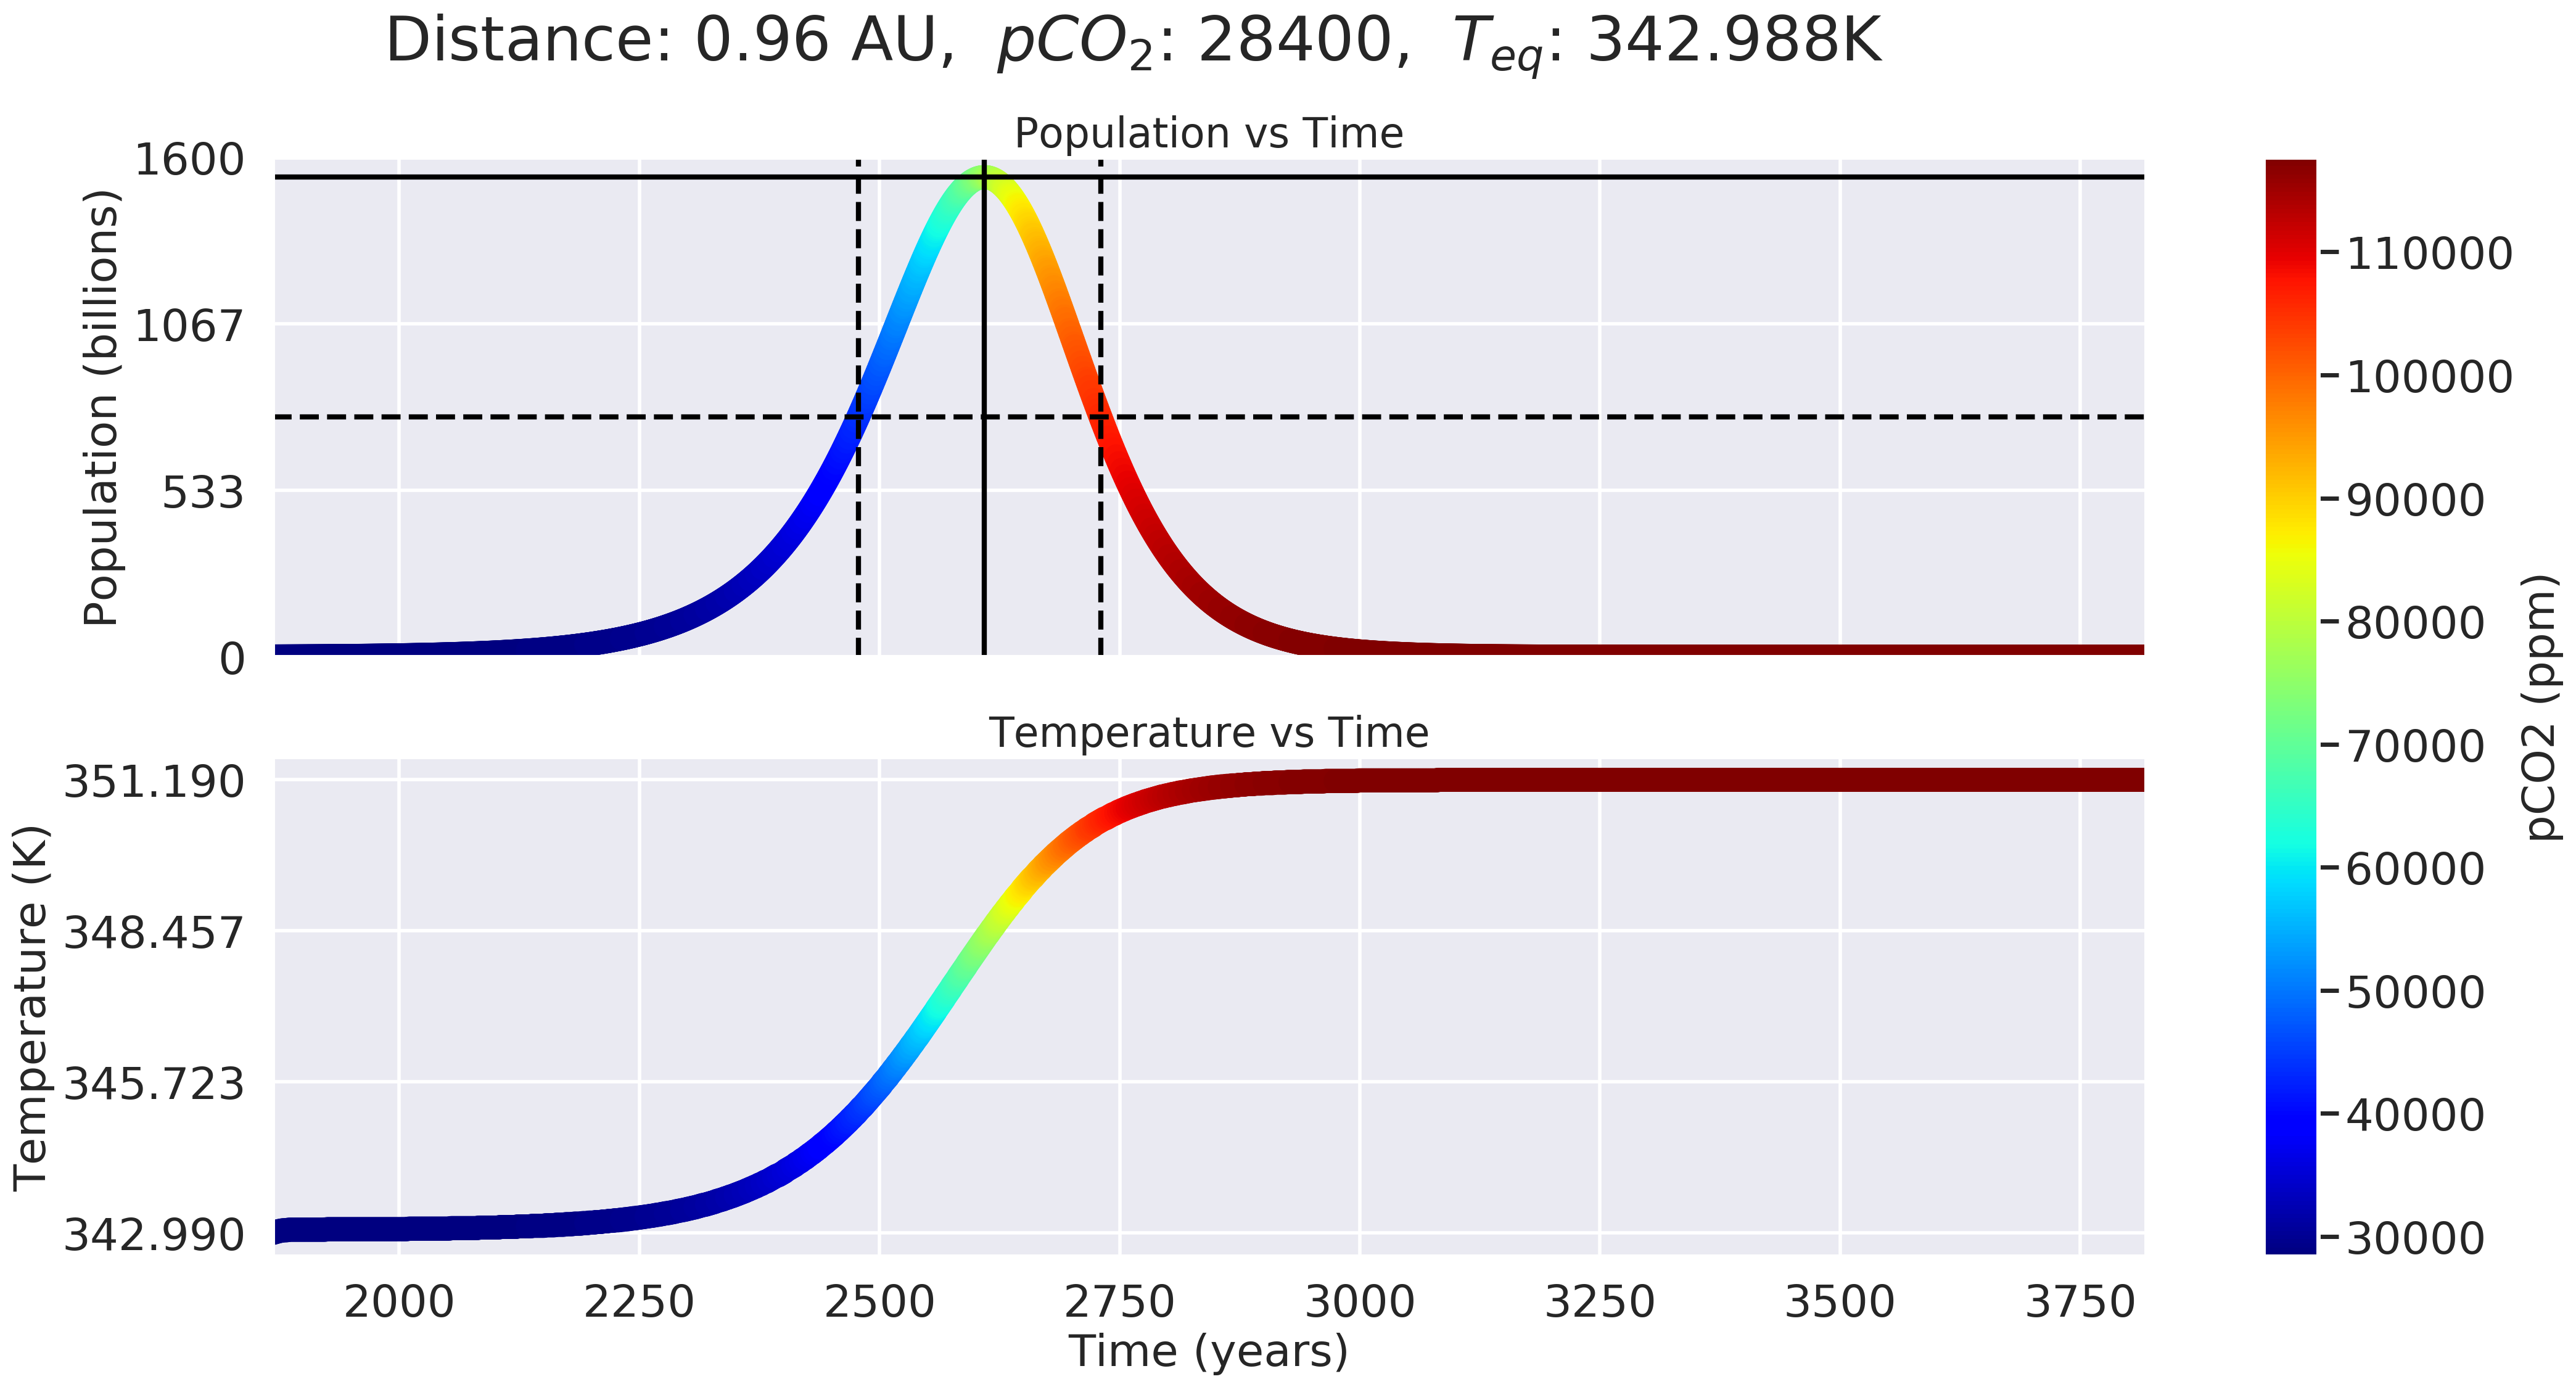

In [3]:
inputs=[newA,newPco2]
maxima = dfModel.max();#find maxima from all columns in df
maxPop = maxima[3];#find maxima in population column, peak popultion
#print(maxPop)#peak population
maxPopIndex = dfModel.loc[dfModel['pop']==maxPop].index#search rows for index of max pop
maxPopTime=dfModel.iloc[maxPopIndex]['time_yrs'];#search column for time until peak pop is reached

halfPop=maxPop/2;
halfPopIndex = dfModel.loc[dfModel['pop']==halfPop].index#search rows for index of max pop
halfPopTime=dfModel.iloc[maxPopIndex]['time_yrs'];#search column for time until peak pop is reached
#print(maxPop/2)
#while newDF.shape[0]>=2:
#     newDF= dfModel.loc[(dfModel['pop'] > (halfPop-dP)) & (dfModel['pop'] < (halfPop+dP))]
#     dT+=1
#     print("dT: "+ str(dT))

LhalfPop=0;
UhalfPop=0;
dP=50
count=1
while True:    
    newDF= dfModel.loc[(dfModel['pop'] > (halfPop-dP)) & (dfModel['pop'] < (halfPop+dP))]
    if(newDF.shape[0]>=2):
        break
    dP+=100
    count+=5
#print(dP)
#print(newDF)
#print()
try:
    if(nameList['ebm']['coupled']):
        LhalfPop = float(newDF.time_yrs[:-1])
        UhalfPop = float(newDF.time_yrs[-1:])
except TypeError:
    print('')
maxPopPlot=maxPop/1000;
#maxPopPlot=40
#dictionary of population statistics
popStats={'maxPop' : (maxPop/1000), 'maxTime': maxPopTime.mean(),
          'halfPop': (halfPop/1000),'halfTime': halfPopTime.mean(),
          'LhalfPop': LhalfPop,#gets first row, casts as double
          'UhalfPop': UhalfPop,#gets last row, " " 
          'maxPopPlot': 1600}#maximum plotting range for population
#-----------------------------------PLOTS----------------------------------------------------------
if equilibrium: plotModelOutput(dfModel,inputs,eqTime,eqTemp,popStats)#plot the output of our model, colored by pco2 
#dfTemp = pd.read_csv('anomaly.csv');#data from NASA GISS: https://data.giss.nasa.gov/gistemp/graphs_v4/
#dfPopCo2 = pd.read_csv('world_stats.csv');#data from Frank, Adam, and Woodruff Sullivan.
#plotModelInput(nameList)#plot the temperature dependence on the growth rate
#plotTruePopCo2(dfPopCo2) #plot true population values vs pco2
#compareModelOutput(dfModel,dfTemp,dfPopCo2)#compare the models output to true data